In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ephem
from datetime import datetime
import math
import random
from numpy import random
import os
import warnings

import matplotlib.dates as mdates

import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda")
torch.tensor([1.]).to(device)
from torch.utils.data import DataLoader, TensorDataset


import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C,DQN,PPO
from stable_baselines3.common.env_util import make_vec_env

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from PPOor import PPO  
import wandb



In [21]:
train_set = pd.read_csv('Useful data/train_final3.csv')
ctrl_set = pd.read_csv('Useful data/ctrl_final3.csv')

### Set baseline method as in the Test department for the Control department

In [22]:
train_baseline = train_set[['Date','Time','Temperature setting','Bandwidth','Minimum ventilation','Maximum ventilation']]

In [23]:
ctrl_set.drop(['Temperature setting','Bandwidth','Minimum ventilation','Maximum ventilation'], axis=1, inplace=True)
ctrl_set = pd.merge(ctrl_set, train_baseline, on=['Date', 'Time'], how='inner')

C:\Users\aleza\AppData\Local\Temp\ipykernel_11580\2408523139.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainr2['Datetime'] = pd.to_datetime(trainr2['Date'] + ' ' + trainr2['Time'])
C:\Users\aleza\AppData\Local\Temp\ipykernel_11580\2408523139.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainr2['Pig_Age'] = (trainr2['Datetime'].dt.normalize() - first_date).dt.days + 7
C:\Users\aleza\AppData\Local\Temp\ipykernel_11580\2408523139.py:11: SettingWithCopyWarning: 
A value is trying to be set on a

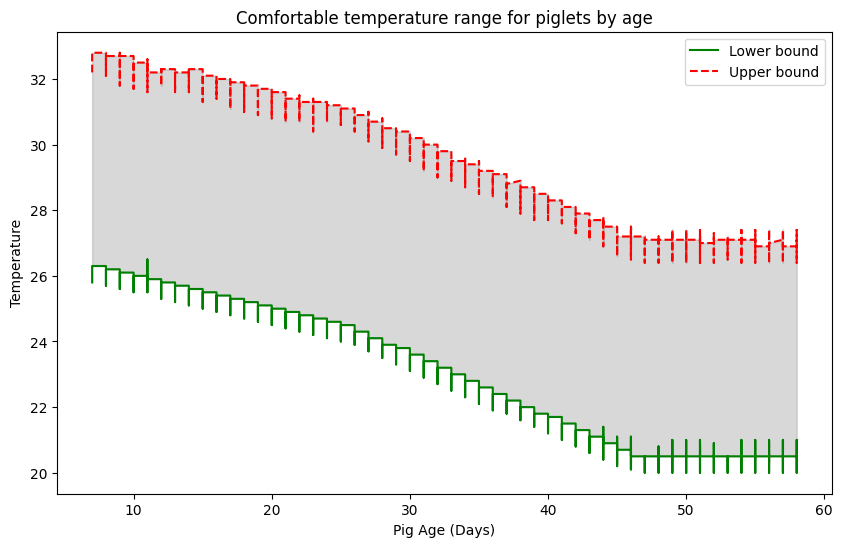

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

trainr2 = train_set[train_set['Round'] == 2]

trainr2['Datetime'] = pd.to_datetime(trainr2['Date'] + ' ' + trainr2['Time'])

first_date = trainr2['Datetime'].min().normalize()  
trainr2['Pig_Age'] = (trainr2['Datetime'].dt.normalize() - first_date).dt.days + 7

trainr2['Temp_Bandwidth'] = trainr2['Temperature setting'] + trainr2['Bandwidth']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(trainr2['Pig_Age'], trainr2['Temperature setting'], color='green', label='Lower bound')
plt.plot(trainr2['Pig_Age'], trainr2['Temp_Bandwidth'], color='red', linestyle='--', label='Upper bound')
plt.fill_between(trainr2['Pig_Age'], trainr2['Temperature setting'], 
                 trainr2['Temp_Bandwidth'], color='grey', alpha=0.3)

# Adding labels and title
plt.xlabel('Pig Age (Days)')
plt.ylabel('Temperature')
plt.title('Comfortable temperature range for piglets by age')
plt.legend()

plt.show()


# Final Equation


In [25]:
# volume
V = 9.69*31*3

# Constants for air density
R_dry_air = 287.05  # Specific gas constant for dry air (J/kg K)
P_atm = 101325  

# Constants for specific heat capacity
C_pd_dry_air = 1005  # Specific heat capacity of dry air at constant pressure (J/(kg·K))
C_pv_water_vapor = 1860  # Specific heat capacity of water vapor at constant pressure (J/(kg·K))

#Constant for Qe
Ac = 31 * 3 * 2 + 9.69*3*2 + 31*9.69

# Constants for Qfh
S_g = 31*9.69

# Sun Coefficient
pr = 0.027

# Ke / wall thickness
ks_L = 4.303

# floor transmission coefficient
h_g = 33.426

# constant for heating
k = 3.878

#constant for heating 2
k1 = 36.61

def calculate_air_density(relative_humidity, ti):
    temperature_K = ti + 273.15  # Convert temperature to Kelvin

    # Convert relative humidity from percentage to fraction
    relative_humidity_fraction = relative_humidity / 100

    # Calculate vapor pressure of water vapor (Pa)
    e = 6.112 * math.e**((17.67 * ti) / (ti + 243.5)) * relative_humidity_fraction

    # Calculate partial pressure of dry air (Pa)
    P_dry_air = P_atm - e

    # Calculate air density (kg/m³)
    air_density = P_dry_air / (R_dry_air * temperature_K)

    return air_density

# Function to calculate specific heat capacity of moist air
def calculate_specific_heat_capacity(humidity):
    # Mass fraction of dry air and water vapor
    relative_humidity = humidity / 100
    f_dry_air = 1 - relative_humidity
    f_water_vapor = relative_humidity

    # Calculate specific heat capacity of moist air
    C_p_moist_air = f_dry_air * C_pd_dry_air + f_water_vapor * C_pv_water_vapor

    return C_p_moist_air

def Qr(Id_areahit, pr):
    return Id_areahit * pr

def Qv(rh, Cv, Ct, Tf): #Ct is Current temperature
    air_dens = calculate_air_density(rh, Ct)
    heat_cap = calculate_specific_heat_capacity(rh)
    return (air_dens * heat_cap * Cv/100 * (25*700/3600) * (Tf - Ct))


def Qe(Ti, To, ks_L):
    return(ks_L * Ac * (To - Ti))


def Qfh(Ti,tp,h_g):
    return (S_g * h_g * (tp - Ti))


def Qp(qpig, ti, n = 700):
    qp = qpig * n
    return qp + qp*(-0.012*(ti-20))

def Qh_(heat_cap, k, To):
    if To > 8:
        val = 0
    elif To <= 8:
        val = heat_cap*k*(10 - To)
    
    return val


def Qh2_(k1, To):
    if To > 15:
        val = 0
    elif To <= 15:
        val = 100
    else:
        val = -100/3*To+500
    
    return k1 * val


def change_rate_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap):
    air_dens = calculate_air_density(rh, ti)
    qe = Qe(ti, to, ks_L)
    qv = Qv(rh, Cv, Ct, to) 
    qfh = Qfh(ti,tp,h_g)
    qp = Qp(BSA,ti)
    increment = (qh + qh2 + qe + qv + qfh + qp + qr) / (air_dens * heat_cap * V)
    return increment

def rk4_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, h = 300):
    inc1 = change_rate_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap)
    inc2 = change_rate_faster(ti + inc1 * h/2, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap)
    inc3 = change_rate_faster(ti + inc2* h/2, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap)
    inc4 = change_rate_faster(ti + h*inc3, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap)

    return ti + (inc1 + 2*inc2 + 2*inc3 + inc4)/6


def rk42_faster2(ti, to, tp, Ct, rh, Id_areahit, Cv, BSA, k, k1, ks_L, h_g, pr, hi=150):
    heat_cap = calculate_specific_heat_capacity(rh)
    qr = Qr(Id_areahit, pr)
    qh = Qh_(heat_cap, k, to)
    qh2 = Qh2_(k1, to)
    steps = int(300/hi)
    for i in range(1, steps):
        ti = rk4_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, hi)
    return ti


# Agent

In [26]:
class PigEnv(gym.Env):
    def __init__(self, df, power_cost=1):
        self.action_space = spaces.Box(low=np.float32(-1), high=np.float32(1), shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            np.array([0, 0, 0, -20, 0, 0, 11], dtype=np.float32),
            np.array([40, 24, 107215, 40, 100, 250, 33], dtype=np.float32),
            shape=(7,), dtype=np.float32
        )
        self.initial_episode_length = 2 * 24 * 60 * 60  
        self.interval = 5 * 60
        self.steps = self.initial_episode_length // self.interval
        self.current_step = 0
        self.df = df
        self.power_cost = power_cost
        self.temp_in = self.df.loc[0, 'Inside temperature']

        # Initialize the RNG for this environment
        self.np_random = None
        self.seed()


    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]


    def _get_obs(self):
        self.time = self.df.loc[self.current_step, 'hour']
        self.sun = self.df.loc[self.current_step, 'Id_areahit']
        self.temp_out = self.df.loc[self.current_step, 'T- Inlet behind conditioner']
        self.humidity = self.df.loc[self.current_step, 'humidity']
        self.BSA = self.df.loc[self.current_step, 'Qpig']
        #Update minimum ventilation, maximum ventilation, bandwidth and temperature setting
        self.minvent = self.df.loc[self.current_step, 'Minimum ventilation']
        self.maxvent = self.df.loc[self.current_step, 'Maximum ventilation']
        self.bandwidth = self.df.loc[self.current_step, 'Bandwidth']
        self.mintemp = self.df.loc[self.current_step, 'Temperature setting']
        return np.array([self.temp_in, self.time, self.sun, self.temp_out, self.humidity, self.BSA, self.minvent], dtype=np.float32)


    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.current_step = 0  # Reset step counter
        self.episode_length = self.initial_episode_length 
        # Reset initial temperature as the first row's inside temperature
        self.temp_in = self.df.loc[0, 'Inside temperature']
        observation = self._get_obs()
        info = {}
        return observation, info


    def step(self, action): 
        if isinstance(action, np.ndarray):
            action = action[0]

        scaled_action = (action + 1) * (105 / 2)
        scaled_action = np.clip(scaled_action, self.minvent, 105)

        self.temp_in = float(rk42_faster2(
            self.temp_in, self.temp_out, 29.5, self.temp_in, self.humidity, 
            self.sun, scaled_action, self.BSA, k, k1, ks_L, h_g, pr, hi=150
        ))

        self.episode_length -= self.interval
        self.current_step += 1

        if self.current_step >= len(self.df):  # Check to avoid going out of bounds
            done = True
            self.current_step = len(self.df) - 1  # Prevent index out of bounds
        else:
            done = self.episode_length <= 0

        #to track during training
        temp_in_range = 0

        if self.temp_in > (self.mintemp + self.bandwidth):
            reward = -(self.temp_in - self.bandwidth - self.mintemp)
        elif self.temp_in < self.mintemp:
            reward = -(self.mintemp - self.temp_in)
        else:
            reward = 0
            temp_in_range = 1

        step_power_cost = self.power_cost * scaled_action

        #Night time correction:
        if self.time > 22 or self.time < 8:
            step_power_cost *= 0.9794
            
        reward += -step_power_cost

        reward = float(reward)
        truncated = self.current_step >= len(self.df) - 1  # Truncate at the last index
        observation = self._get_obs()
        info = {'action': scaled_action, 'temp_in': self.temp_in, 'temp_out': self.temp_out, 'reward': reward, 'temp_in_range': temp_in_range}
        return observation, reward, done, truncated, info


    def render(self):
        pass


## Check if agent works

In [27]:
env = PigEnv(df=train_set, power_cost=1)
check_env(env, warn=True)

# Run a few episodes to manually check the environment's behavior
num_episodes = 5
for episode in range(num_episodes):
    observation, info = env.reset()
    done = False
    truncated = False
    total_reward = 0
    
    print(f"Episode {episode + 1} starting...")
    while not done and not truncated:
        action = env.action_space.sample()  
        observation, reward, done, truncated, info = env.step(action)
        total_reward += reward
        print(f"Step: {env.current_step}, Action: {action}, Reward: {reward}, Done: {done}, Truncated: {truncated}")
    
    print(f"Episode {episode + 1} finished with total reward: {total_reward}\n")

Episode 1 starting...
Step: 1, Action: [0.23290849], Reward: -64.72769558429718, Done: False, Truncated: False
Step: 2, Action: [-0.6773372], Reward: -16.939795464277267, Done: False, Truncated: False
Step: 3, Action: [-0.51759434], Reward: -25.326297283172607, Done: False, Truncated: False
Step: 4, Action: [-0.11527115], Reward: -46.44826456904411, Done: False, Truncated: False
Step: 5, Action: [-0.48654923], Reward: -26.9561655074358, Done: False, Truncated: False
Step: 6, Action: [0.32181683], Reward: -69.3953836709261, Done: False, Truncated: False
Step: 7, Action: [-0.02785999], Reward: -51.03735045064241, Done: False, Truncated: False
Step: 8, Action: [-0.19995224], Reward: -42.00250715017319, Done: False, Truncated: False
Step: 9, Action: [0.5756704], Reward: -82.722697108984, Done: False, Truncated: False
Step: 10, Action: [0.8110898], Reward: -95.0822152197361, Done: False, Truncated: False
Step: 11, Action: [0.89136463], Reward: -99.29664328694344, Done: False, Truncated: Fal

# Behavioral cloning

## I define an train the supervised network

In [57]:
class VentilationNet(nn.Module):
    def __init__(self):
        super(VentilationNet, self).__init__() 
        self.actor = nn.Sequential(
            nn.Linear(7, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.actor(x)
    

## Simulated dataframe appraoch

In [9]:
Modeldata = train_set[['hour','Id_areahit','T- Inlet behind conditioner','humidity','Qpig','Minimum ventilation','Temperature setting','Bandwidth','Maximum ventilation']]

In [101]:
sequence = np.arange(22, 31.1, 0.1)
tempsdata = pd.DataFrame(sequence, columns = ['Inside temperature'])

In [102]:
Modeldata['key'] = 1
tempsdata['key'] = 1

merged_data = pd.merge(Modeldata, tempsdata, on='key')
merged_data = merged_data.drop('key', axis=1)

C:\Users\aleza\AppData\Local\Temp\ipykernel_23604\4217634550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Modeldata['key'] = 1


In [104]:
states  = []
actions = []
for i in range(len(merged_data)):
    maxvent = merged_data.loc[i, 'Maximum ventilation']
    bandwith = merged_data.loc[i, 'Bandwidth']
    mintemp = merged_data.loc[i, 'Temperature setting']
    minvent = merged_data.loc[i, 'Minimum ventilation']
    maxtemp = mintemp + bandwith
    temp = merged_data.loc[i, 'Inside temperature']
    
    # Calculate real action based on temperature and ventilation bounds
    m = (maxvent - minvent) / (maxtemp - mintemp)
    c = minvent - m * mintemp
    action = m * temp + c
    action = np.clip(action, minvent, maxvent)
    state = [
        merged_data.loc[i, 'Inside temperature'],
        merged_data.loc[i, 'hour'],
        merged_data.loc[i, 'Id_areahit'],
        merged_data.loc[i, 'T- Inlet behind conditioner'],
        merged_data.loc[i, 'humidity'],
        merged_data.loc[i, 'Qpig'],
        merged_data.loc[i, 'Minimum ventilation']
    ]
    
    states.append(state)
    actions.append(action)

states = np.array(states, dtype=np.float32)
actions = np.array(actions, dtype=np.float32)

In [115]:
torch.device("cuda")

def BC_train_validation(path, l_r=1e-3, val_split=0.2, starting_weights=None):
    # Seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = VentilationNet()
    if starting_weights is not None:
        model.load_state_dict(torch.load(starting_weights))

    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=l_r)

    # Normalization bounds (from the PigEnv environment)
    state_min = np.array([0, 0, 0, -20, 0, 0, 11], dtype=np.float32)
    state_max = np.array([40, 24, 107215, 40, 100, 250, 33], dtype=np.float32)

    # Normalize the states
    states_normalized = (states - state_min) / (state_max - state_min)

    states_tensor = torch.tensor(states_normalized, dtype=torch.float32)
    actions_tensor = torch.tensor(actions, dtype=torch.float32)

    X_train, X_val, y_train, y_val = train_test_split(
        states_tensor, actions_tensor, test_size=val_split, random_state=seed
    )

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    batch_size = 256  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    num_epochs = 600  # Number of epochs

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # To accumulate the loss over each epoch

        for batch_states, batch_actions in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            # print(batch_states[0])
            outputs = model(batch_states).squeeze()

            # Compute the loss
            loss = criterion(outputs, batch_actions)

            # Backward pass: Compute gradients
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the training loss
            running_loss += loss.item()

        # Compute the average training loss
        avg_train_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for val_states, val_actions in val_loader:
                # Forward pass: Get model predictions
                val_outputs = model(val_states).squeeze()

                # Compute the loss for validation
                val_loss += criterion(val_outputs, val_actions).item()

        # Compute the average validation loss
        avg_val_loss = val_loss / len(val_loader)

        # Print the training and validation loss every epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}')

    # Save the trained model
        if (epoch+1)%100 == 0:
            torch.save(model.state_dict(), 'Ventilation weights/' + f'epoch{epoch+1}' + path)


In [116]:
BC_train_validation('ventilation_netval.pth')

Epoch [1/600], Train Loss: 147.2213, Val Loss: 37.5991
Epoch [2/600], Train Loss: 33.6237, Val Loss: 29.6932
Epoch [3/600], Train Loss: 26.4190, Val Loss: 24.7628
Epoch [4/600], Train Loss: 23.9529, Val Loss: 23.2716
Epoch [5/600], Train Loss: 23.0578, Val Loss: 22.4840
Epoch [6/600], Train Loss: 22.4711, Val Loss: 22.3657
Epoch [7/600], Train Loss: 22.1201, Val Loss: 22.2049
Epoch [8/600], Train Loss: 21.7941, Val Loss: 21.4954
Epoch [9/600], Train Loss: 21.4172, Val Loss: 21.2196
Epoch [10/600], Train Loss: 20.6349, Val Loss: 20.0043
Epoch [11/600], Train Loss: 19.2436, Val Loss: 17.7081
Epoch [12/600], Train Loss: 15.9207, Val Loss: 15.1974
Epoch [13/600], Train Loss: 14.9173, Val Loss: 14.6553
Epoch [14/600], Train Loss: 14.6654, Val Loss: 14.4496
Epoch [15/600], Train Loss: 14.4456, Val Loss: 14.3420
Epoch [16/600], Train Loss: 14.2604, Val Loss: 14.3102
Epoch [17/600], Train Loss: 14.1075, Val Loss: 14.3604
Epoch [18/600], Train Loss: 13.9188, Val Loss: 13.7939
Epoch [19/600], Tr

# BC Test

In [9]:
myenv = PigEnv(df=train_set)
myenv.reset()  # Reset environment before the loop
state, _ = myenv.reset()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VentilationNet()
model.load_state_dict(torch.load('Ventilation weights/epoch600ventilation_netval.pth'))
model.to(device)

done = False
base_action = []
ventnet_action = []
dates = []
state_min = np.array([0, 0, 0, -20, 0, 0, 11], dtype=np.float32)
state_max = np.array([40, 24, 107215, 40, 100, 250, 33], dtype=np.float32)

for _ in range(len(train_set)):
    # if done: 
    #     state, _ = myenv.reset() 
    #     done = False  
    mintemp = myenv.df.loc[myenv.current_step, 'Temperature setting']
    minvent = myenv.df.loc[myenv.current_step, 'Minimum ventilation']
    maxvent = myenv.df.loc[myenv.current_step, 'Maximum ventilation']
    bandwith = myenv.df.loc[myenv.current_step, 'Bandwidth']
    maxtemp = mintemp + bandwith
    temp = myenv.temp_in

    # Calculate realaction
    m = (maxvent - minvent) / (maxtemp - mintemp)
    c = minvent - m * mintemp
    realaction = m * temp + c
    realaction = np.clip(realaction, minvent, maxvent)

    # print(minvent, maxvent, realaction)

    # Scale realaction to be used by environment
    envaction = realaction * 2 / 105 - 1
    

    # Normalize the states
    state_normalized = (state - state_min) / (state_max - state_min)
  
    model_action = model(torch.tensor(state_normalized, dtype=torch.float32).to(device))
    model_action = (model_action.detach().cpu().numpy())

    # print(state[0], realaction)

    # print(f'real action: {realaction}, model action: {model_action}, state: {state}')

    # Take a step in the environment
    state, _, done, _, _ = myenv.step(envaction)  # Adjust to correct return format

    # Pass state to the model
    
    # print(model_action)

    # Store actions
    dates.append(myenv.df.loc[myenv.current_step, 'Date'])
    base_action.append(realaction)
    ventnet_action.append(model_action) 

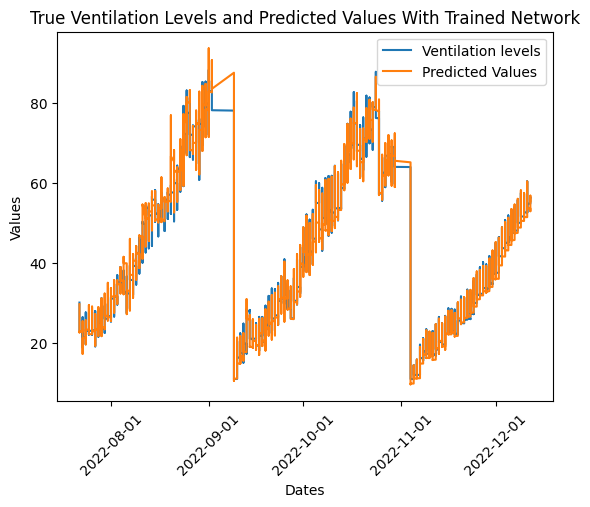

In [28]:
dates = pd.to_datetime(dates)
plt.figure()

# Plot the base_action and ventnet_action with dates as the x-axis
plt.plot(dates, base_action, label='Ventilation levels')
plt.plot(dates, ventnet_action, label='Predicted Values')

# Add labels and legend
plt.xlabel('Dates')
plt.ylabel('Values')
plt.title('True Ventilation Levels and Predicted Values With Trained Network')
plt.legend()

# Use an AutoDateLocator to show fewer dates on the x-axis
locator = mdates.AutoDateLocator()  # Automatically selects the best date interval
plt.gca().xaxis.set_major_locator(locator)

# Optionally, format the date to make it readable
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


MAE: 1.1779808
R-squared: 0.9916128597018098
Slope: 0.983063811622701
Intercept: 0.46620199428663195
Error SD: 1.7233908


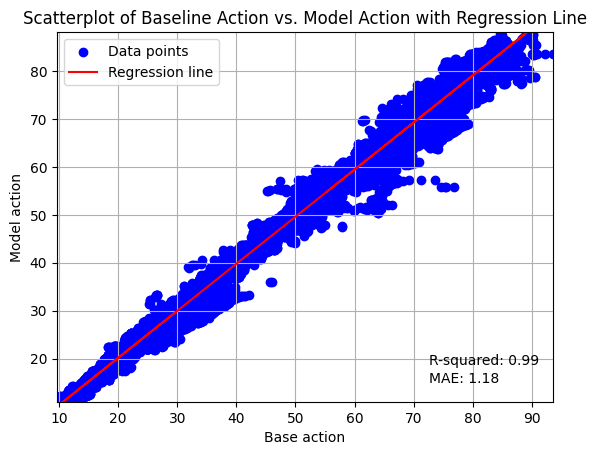

In [10]:
bases = np.array(base_action, dtype=np.float32)  # Convert to float32
ventnets = np.ravel(np.array(ventnet_action, dtype=np.float32))

# Compute mean absolute error (MAE) using vectorized operations
mae = []
ss_res = 0
ss_tot = 0
ventnets_vals = []
bases_vals = []

for i in range(len(bases)):
    mae.append(abs(bases[i] - ventnets[i]))
    ventnets_vals.append(ventnets[i])
    bases_vals.append(bases[i])

mae = np.mean(mae)
mean_bases = np.mean(bases_vals)

print('MAE:', mae)

# Perform a linear regression to get the coefficients
coeffs = np.polyfit(ventnets_vals, bases_vals, 1)  # 1 indicates a linear fit (degree 1)
slope = float(coeffs[0])  # Ensure slope is a scalar (float)
intercept = float(coeffs[1])  # Ensure intercept is a scalar (float)

# Generate the regression line based on the coefficients using ventnets as the independent variable
regression_line = slope * np.array(ventnets_vals) + intercept

# Calculate residuals and the sum of squares
residuals = []
for i in range(len(ventnets_vals)):
    residual = bases_vals[i] - regression_line[i]  # Residual calculation: actual - predicted
    residuals.append(residual)
    ss_res += residual ** 2
    ss_tot += (bases_vals[i] - mean_bases) ** 2

r_squared = 1 - (ss_res / ss_tot)

print('R-squared:', r_squared)
print('Slope:', slope)
print('Intercept:', intercept)

# Calculate the standard deviation of the residuals (error SD)
error_sd = np.std(residuals, ddof=1)
print('Error SD:', error_sd)

# Plotting the regression results for better visualization
plt.scatter(ventnets_vals, bases_vals, label='Data points', color='blue')  # Scatter plot for data points
plt.plot(ventnets_vals, regression_line, color='red', label='Regression line')  # Regression line

# Add labels for axes
plt.xlabel('Base action')  # Independent variable label
plt.ylabel('Model action')  # Dependent variable label

# Set limits for the plot based on data range
plt.xlim([min(ventnets_vals), max(ventnets_vals)])
plt.ylim([min(bases_vals), max(bases_vals)])

# Annotate the plot with MAE and R-squared values
plt.text(0.75, 0.05, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(0.75, 0.1, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes)

# Show the legend and the plot
plt.legend()
plt.grid(True)  # Optional: add a grid for better visualization
plt.title('Scatterplot of Baseline Action vs. Model Action with Regression Line')
plt.show()

# PPO Training

## Creating a training and test set.
To obtain more training data, multiple batches were defined using a sliding window

In [28]:
def train_test_split_batches(round=0, batch_size=576, overlap=144, num_overlaps=3):
    if round == 0:
        tdf = train_set
        cdf = ctrl_set
    else:
        tdf = train_set[train_set['Round'] == round]
        cdf = ctrl_set[ctrl_set['Round'] == round]
    
    def create_multiple_sliding_window_batches(df, batch_size, overlap, num_overlaps):
        all_batches = []
        for i in range(num_overlaps):
            start = i * overlap  # Starting point shifts for each overlap pass
            batches = []
            while start + batch_size <= len(df):
                batch = df.iloc[start:start + batch_size].reset_index(drop=True)
                batches.append(batch)
                start += (batch_size - overlap)  # Slide the window for the next batch
            all_batches.extend(batches)
        return all_batches

    tbatches = create_multiple_sliding_window_batches(tdf, batch_size, overlap, num_overlaps)
    cbatches = create_multiple_sliding_window_batches(cdf, batch_size, overlap, num_overlaps)

    # Shuffle the batches
    tbatches = shuffle(tbatches, random_state=123)
    cbatches = shuffle(cbatches, random_state=123)

    # Determine the number of test batches (10% of total batches)
    t_num_test_batches = max(1, int(len(tbatches) * 0.1))
    c_num_test_batches = max(1, int(len(cbatches) * 0.1))

    # Split into test and train batches
    ttest_batches = tbatches[:t_num_test_batches]
    ttrain_batches = tbatches[t_num_test_batches:]

    ctest_batches = cbatches[:c_num_test_batches]
    ctrain_batches = cbatches[c_num_test_batches:]

    train_batches = ttrain_batches + ctrain_batches
    test_batches = ttest_batches + ctest_batches

    return train_batches, test_batches

dfsummer_train, dfsummer_test = train_test_split_batches(round=1, batch_size=576, overlap=144, num_overlaps=3)
dffall_train, dffall_test = train_test_split_batches(round=2, batch_size=576, overlap=144, num_overlaps=3)
dfwinter_train, dfwinter_test = train_test_split_batches(round=3, batch_size=576, overlap=144, num_overlaps=3)
dfcomplete_train = dfsummer_train + dffall_train + dfwinter_train
dfcomplete_test = dfsummer_test + dffall_test + dfwinter_test


## Training script

In [29]:
## HYPERPARAMETERS FOR FIRST TRAINING
max_ep_len = 576   # max timesteps in one episode, set to the batch size (2 days)
max_training_timesteps = int(1e6) 

print_freq = max_ep_len * 8     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 4       # log avg reward in the interval (in num timesteps)
save_model_freq = int(5e5)      # save model frequency (in num timesteps)

action_std = 6  # starting std for action distribution (Multivariate Normal)
min_action_std = 0.1 # minimum action_std (stop decay after action_std <= min_action_std)
totstep_decay = int(1e6) #num timesteps to end decay (the std decreases linearly over totstep_decay timesteps)

step_decay = (action_std - min_action_std) / totstep_decay

################ PPO hyperparameters ################
update_timestep = max_ep_len * 2      # update policy every n timesteps
K_epochs = 100               # update policy for K epochs in one PPO update
eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99

#Tensors to normalize states
state_min = np.array([0, 0, 0, -20, 0, 0, 11], dtype=np.float32)
state_max = np.array([40, 24, 107215, 40, 100, 250, 33], dtype=np.float32)

In [11]:
np.random.seed(42) #seed for batch splitting

def train(data, period = "", num_epochs=100, p_c = 0, trainseed = 123, LRactor = 0.004, path = None):
    print("============================================================================================")

    ####### initialize environment hyperparameters ######
    env_name = "PigEnv"
    pc = p_c # Power cost

    # Load your dataframe (df) here
    df = data  # Replace with code to load your dataframe
    batches = df # Split the dataframe into batches of 288 observations

    has_continuous_action_space = True  

    step_decay = (action_std - min_action_std) / totstep_decay

    ## Note : print/log frequencies should be > than max_ep_len

    ################ PPO hyperparameters ################
    lr_actor = LRactor       # learning rate for actor network
    lr_critic = LRactor * 0.5       # learning rate for critic network

    random_seed = trainseed         # set random seed if required (0 = no random seed)
    #####################################################

    print("training environment name : " + env_name)

    # state space dimension
    env = PigEnv(batches[0], power_cost=pc)  # Initialize environment with the first batch to get dimensions
    state_dim = env.observation_space.shape[0]

    # action space dimension
    if has_continuous_action_space:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n

    ###################### logging ######################

    #### log files for multiple runs are NOT overwritten
    log_dir = "PPO_logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    log_dir = log_dir + '/' + env_name + '/'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    #### get number of log files in log directory
    run_num = 0
    current_num_files = next(os.walk(log_dir))[2]
    run_num = len(current_num_files)

    #### create new log file for each run
    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

    print("current logging run number for " + env_name + " : ", run_num)
    print("logging at : " + log_f_name)
    #####################################################

    ################### checkpointing ###################
    run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

    directory = "PPO_preTrained"
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory = directory + '/' + env_name + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)

    checkpoint_path = directory + "PPO_{}_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained,period)
    print("save checkpoint path : " + checkpoint_path)
    #####################################################


    ############# print all hyperparameters #############
    print("--------------------------------------------------------------------------------------------")
    print("max training timesteps : ", max_training_timesteps)
    print("max timesteps per episode : ", max_ep_len)
    print("model saving frequency : " + str(save_model_freq) + " timesteps")
    print("log frequency : " + str(log_freq) + " timesteps")
    print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")
    print("--------------------------------------------------------------------------------------------")
    print("state space dimension : ", state_dim)
    print("action space dimension : ", action_dim)
    print("--------------------------------------------------------------------------------------------")
    if has_continuous_action_space:
        print("Initializing a continuous action space policy")
        print("--------------------------------------------------------------------------------------------")
        print("starting std of action distribution : ", action_std)
        # print("decay rate of std of action distribution : ", action_std_decay_rate)
        print("minimum std of action distribution : ", min_action_std)
        # print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")
    else:
        print("Initializing a discrete action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("PPO update frequency : " + str(update_timestep) + " timesteps")
    print("PPO K epochs : ", K_epochs)
    print("PPO epsilon clip : ", eps_clip)
    print("discount factor (gamma) : ", gamma)
    print("--------------------------------------------------------------------------------------------")
    print("optimizer learning rate actor : ", lr_actor)
    print("optimizer learning rate critic : ", lr_critic)
    if random_seed:
        print("--------------------------------------------------------------------------------------------")
        print("setting random seed to ", random_seed)
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)
    #####################################################

    print("============================================================================================")

    ################# training procedure ################

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
    
    if path is None:
        ppo_agent.load2('Ventilation weights/epoch600ventilation_netval.pth')
    else:
        ppo_agent.load(path)

    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    print("============================================================================================")

    # logging file
    log_f = open(log_f_name, "w+")
    log_f.write('epoch,episode,timestep,reward\n')

    wandb.init(project='Thesis', entity='alessandrozarfati1-liacs')
    wandb.run.name = 'newrun'
    wandb.watch(ppo_agent.policy_old)

    # training loop
    time_step1 = 0

    for epoch in range(num_epochs):
        #to track how many times the temp is in range
        temp_in_range = []

        np.random.shuffle(batches)  # Shuffle the batches at the beginning of each epoch

        print_running_reward = 0
        print_running_episodes = 0

        log_running_reward = 0
        log_running_episodes = 0

        i_episode = 0
        time_step = 0
        
        for batch in batches:
            env = PigEnv(batch, power_cost=pc)  # Initialize environment with the current batch
            env.current_step = 0  # Reset current_step for each batch

            for _ in range(len(batch) // max_ep_len):  # Iterate over episodes within the batch
                state, _ = env.reset()
                current_ep_reward = 0

                for t in range(1, max_ep_len + 1):

                    # select action with 
                    state_normalized = (state - state_min) / (state_max - state_min)
  
                    action = ppo_agent.select_action(state_normalized)
                    action = np.clip(action, 0, 105)
                
                    envaction = action*2/105 - 1
            
                    state, reward, done, truncated, info = env.step(envaction)

                    temp_in_range.append(info['temp_in_range'])


                    # saving reward and is_terminals
                    ppo_agent.buffer.rewards.append(reward)
                    ppo_agent.buffer.is_terminals.append(done or truncated)

                    time_step += 1
                    time_step1 += 1
                    current_ep_reward += reward

                    wandb.log({'reward': reward}, step=time_step1)
                    wandb.log({'action': info['action']}, step=time_step1)
                    wandb.log({'temp in range': np.mean(temp_in_range)}, step=time_step1)

                    # update PPO agent
                    if time_step % update_timestep == 0:
                        ppo_agent.update()

                    # if continuous action space; then decay action std of output action distribution
                    if has_continuous_action_space:
                        ppo_agent.decay_action_std(step_decay, min_action_std)

                    # log in logging file
                    if time_step % log_freq == 0:

                        # log average reward till last episode
                        log_avg_reward = log_running_reward / log_running_episodes
                        log_avg_reward = round(log_avg_reward, 4)

                        log_f.write('{},{},{},{}\n'.format(epoch + 1, i_episode + 1, time_step, log_avg_reward))
                        log_f.flush()

                        log_running_reward = 0
                        log_running_episodes = 0

                    # printing average reward
                    if time_step % print_freq == 0:

                        # print average reward till last episode
                        print_avg_reward = print_running_reward / print_running_episodes
                        print_avg_reward = round(print_avg_reward, 2)

                        print("Epoch : {} \t Episode : {} \t Timestep : {} \t Average Reward : {} \t Temp_in {} \t Last action {}".format(epoch + 1, i_episode + 1, time_step, print_avg_reward, info['temp_in'], info['action']))

                        print_running_reward = 0
                        print_running_episodes = 0

                    # save model weights
                    if time_step1 % save_model_freq == 0:
                        print("--------------------------------------------------------------------------------------------")
                        print("saving model at : " + checkpoint_path)
                        ppo_agent.save2(checkpoint_path)
                        print("model saved")
                        print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
                        print("--------------------------------------------------------------------------------------------")

                    if time_step1 % 5e4 == 0:
                        print("--------------------------------------------------------------------------------------------")
                        checkpoint_path1 = directory + "PPO_{}_{}_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained,period, time_step1/5e4)
                        print("saving model at : " + checkpoint_path1)
                        ppo_agent.save2(checkpoint_path1)
                        print("model saved")
                        print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
                        print("--------------------------------------------------------------------------------------------")

                    # break; if the episode is over
                    if done or truncated:
                        break

                print_running_reward += current_ep_reward
                print_running_episodes += 1

                log_running_reward += current_ep_reward
                log_running_episodes += 1

                i_episode += 1

    log_f.close()
    env.close()

    # print total training time
    print("============================================================================================")
    end_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)
    print("Finished training at (GMT) : ", end_time)
    print("Total training time  : ", end_time - start_time)
    print("============================================================================================")


In [12]:
if __name__ == '__main__':
    train(dfcomplete_train, period='All', num_epochs=4, p_c=0.0008, trainseed=123, LRactor=5e-5)

training environment name : PigEnv
current logging run number for PigEnv :  132
logging at : PPO_logs/PigEnv//PPO_PigEnv_log_132.csv
save checkpoint path : PPO_preTrained/PigEnv/PPO_PigEnv_123_0_All.pth
--------------------------------------------------------------------------------------------
max training timesteps :  1000000
max timesteps per episode :  576
model saving frequency : 500000 timesteps
log frequency : 2304 timesteps
printing average reward over episodes in last : 4608 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  7
action space dimension :  1
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
starting std of action distribution :  6
minimum std of action distribution :  0.1
--------------------------------------

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Started training at (GMT) :  2024-10-08 02:06:21


wandb: Currently logged in as: alessandrozarfati1 (alessandrozarfati1-liacs). Use `wandb login --relogin` to force relogin


Epoch : 1 	 Episode : 9 	 Timestep : 4608 	 Average Reward : -17.56 	 Temp_in 26.455221506144944 	 Last action 51.87262415885925
Epoch : 1 	 Episode : 17 	 Timestep : 9216 	 Average Reward : -18.18 	 Temp_in 29.629639109390414 	 Last action 41.773465275764465
Epoch : 1 	 Episode : 25 	 Timestep : 13824 	 Average Reward : -26.99 	 Temp_in 26.96694609413312 	 Last action 43.68880033493042
Epoch : 1 	 Episode : 33 	 Timestep : 18432 	 Average Reward : -15.72 	 Temp_in 26.65026860696586 	 Last action 39.63343799114227
Epoch : 1 	 Episode : 41 	 Timestep : 23040 	 Average Reward : -23.64 	 Temp_in 24.84656260058246 	 Last action 60.301924645900726
Epoch : 1 	 Episode : 49 	 Timestep : 27648 	 Average Reward : -23.6 	 Temp_in 24.44949025022312 	 Last action 63.17550927400589
Epoch : 1 	 Episode : 57 	 Timestep : 32256 	 Average Reward : -15.19 	 Temp_in 26.2960658813501 	 Last action 22.8896301984787
Epoch : 1 	 Episode : 65 	 Timestep : 36864 	 Average Reward : -22.6 	 Temp_in 24.2968382765

# Test And Results

In [30]:
state_dim = 7
action_dim = 1
gamma = 0.99
K_epochs = 100
eps_clip = 0.2
has_continuous_action_space = True
action_std = 0.1   

In [31]:
def CustomTest(mydf, num_episodes = 25, baseline = False, path = None, power_cost = 0.04, lr_actor = 1e-4):
# Define parameters for training
    num_episodes = num_episodes  # Number of episodes for training

    # List to store all temperature observations across episodes
    temp_in_range = []
    all_errors = []
    all_costs = []
    all_rewards = []
    Results = []

    # Training loop
    for episode in range(num_episodes):
        df = mydf[episode]
        if df.empty:
            print(f"Episode {episode+1}: DataFrame is empty after slicing from index {start_idx} to {end_idx}.")
            continue
        
        env = PigEnv(df, power_cost=power_cost)
        state, _ = env.reset()

        done = False
        df_info = pd.DataFrame(columns=['Date', 'Time', 'Temperature', 'Lower_bound', 'Upper_bound', 'Cost', 'Reward', 'Round'])
        
        if baseline==False:
            if path == None:
                ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_actor*0.5, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
                warnings.warn("No path provided for the model, initializing a new model with random weights")
                
            else:
                ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_actor*0.5, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
                ppo_agent.load(path)

            while not done:
                state_normalized = (state - state_min) / (state_max - state_min)
                action = ppo_agent.select_action(state_normalized)
                action = np.clip(action, 0, 105)    
                envaction = action*2/105 - 1

                # Collect the indoor temperature at this step
                step_date = env.df.loc[env.current_step, 'Date']
                step_time = env.df.loc[env.current_step, 'Time']
                step_tempin = env.temp_in
                step_Lb = env.mintemp
                step_Ub = env.mintemp + env.bandwidth
                step_round = env.df.loc[env.current_step, 'Round']

                state, reward, done, _, info = env.step(envaction)
                all_costs.append(info['action'])
                all_rewards.append(reward)

                if env.temp_in > (env.mintemp + env.bandwidth):
                    temp_in_range.append(0)
                    all_errors.append(abs(env.temp_in - env.mintemp - env.bandwidth))
                elif env.temp_in < env.mintemp:
                    temp_in_range.append(0)
                    all_errors.append(abs(env.temp_in - env.mintemp))
                else:
                    temp_in_range.append(1)

                new_row = pd.DataFrame({
                    'Date': [step_date],
                    'Time': [step_time],
                    'Temperature': [step_tempin],
                    'Lower_bound': [step_Lb],
                    'Upper_bound': [step_Ub],
                    'Cost': [action[0]],
                    'Reward': [reward],
                    'Round': [step_round]
                })

                df_info = pd.concat([df_info, new_row], ignore_index=True)

        if baseline == True:
            while not done:
                mintemp = env.df.loc[env.current_step, 'Temperature setting']
                minvent = env.df.loc[env.current_step, 'Minimum ventilation']
                maxvent = env.df.loc[env.current_step, 'Maximum ventilation']
                bandwith = env.df.loc[env.current_step, 'Bandwidth']
                maxtemp = mintemp + bandwith
                temp = env.temp_in
                m = (maxvent - minvent) / (maxtemp - mintemp)
                c = minvent - m * mintemp

                action = m * temp + c
                action = np.clip(action, minvent, maxvent)

                all_costs.append(action)   

                envaction = action*2/105 - 1
                
                # Collect the indoor temperature at this step
                step_date = env.df.loc[env.current_step, 'Date']
                step_time = env.df.loc[env.current_step, 'Time']
                step_tempin = env.temp_in
                step_Lb = env.mintemp
                step_Ub = env.mintemp + env.bandwidth
                step_round = env.df.loc[env.current_step, 'Round']

                state, reward, done, _, info = env.step(envaction)
                all_costs.append(info['action'])
                all_rewards.append(reward)

                if env.temp_in > (env.mintemp + env.bandwidth):
                    temp_in_range.append(0)
                    all_errors.append(abs(env.temp_in - env.mintemp - env.bandwidth))
                elif env.temp_in < env.mintemp:
                    temp_in_range.append(0)
                    all_errors.append(abs(env.temp_in - env.mintemp))
                else:
                    temp_in_range.append(1)

                new_row = pd.DataFrame({
                    'Date': [step_date],
                    'Time': [step_time],
                    'Temperature': [step_tempin],
                    'Lower_bound': [step_Lb],
                    'Upper_bound': [step_Ub],
                    'Cost': [action],
                    'Reward': [reward],
                    'Round': [step_round]
                })

                df_info = pd.concat([df_info, new_row], ignore_index=True)
                

        Results.append(df_info)
           
    proportion = np.mean(temp_in_range)
    print("temperature in range: ", round(proportion * 100, 2), "%")
    print("avg cost: ", sum(all_costs) / len(all_costs))
    if len(all_errors) > 0:
        avg_error = np.mean(all_errors) 
        print("avg error: ", avg_error)
    print("avg reward: ", sum(all_rewards) / len(all_rewards))

    return proportion, all_costs, all_errors, all_rewards, Results





def Testall(power_cost = 0.04, path = None):
    warnings.filterwarnings("ignore", category=FutureWarning)
    print("============================================================================================")
    print("Testing the agent.")
    print("path: ", path)
    print("power cost: ", power_cost)
    print("============================================================================================")
    print("Full data test:")
    proportion, all_costs, all_errors, all_rewards, _ = CustomTest(dfcomplete_test, num_episodes = len(dfcomplete_test), baseline = False, power_cost= power_cost, path = path)
    All_test = [proportion, all_costs, all_errors, all_rewards]
    print("----------------------------------------")
    print("Full data Baseline:")
    proportion, all_costs, all_errors, all_rewards, _ = CustomTest(dfcomplete_test, num_episodes = len(dfcomplete_test), baseline = True, power_cost= power_cost)
    All_baseline = [proportion, all_costs, all_errors, all_rewards]
    print("============================================================================================")
    print("Summer data test:")
    proportion, all_costs, all_errors, all_rewards , _= CustomTest(dfsummer_test, num_episodes = len(dfsummer_test), baseline = False, power_cost= power_cost, path = path)
    Summer_test = [proportion, all_costs, all_errors, all_rewards]
    print("----------------------------------------")
    print("Summer data Baseline:")
    proportion, all_costs, all_errors, all_rewards, _ = CustomTest(dfsummer_test, num_episodes = len(dfsummer_test), baseline = True, power_cost= power_cost)
    Summer_baseline = [proportion, all_costs, all_errors, all_rewards]
    print("============================================================================================")
    print("Fall data test:")
    proportion, all_costs, all_errors, all_rewards, _ = CustomTest(dffall_test, num_episodes = len(dffall_test), baseline = False, power_cost= power_cost, path = path)
    Fall_test = [proportion, all_costs, all_errors, all_rewards]
    print("----------------------------------------")
    print("Fall data Baseline:")
    proportion, all_costs, all_errors, all_rewards, _ = CustomTest(dffall_test, num_episodes = len(dffall_test), baseline = True, power_cost= power_cost)
    Fall_baseline = [proportion, all_costs, all_errors, all_rewards]
    print("============================================================================================")
    print("Winter data test:")
    proportion, all_costs, all_errors, all_rewards, _ = CustomTest(dfwinter_test, num_episodes = len(dfwinter_test), baseline = False, power_cost= power_cost, path = path)
    Winter_test = [proportion, all_costs, all_errors, all_rewards]
    print("----------------------------------------")
    print("Winter data Baseline:")
    proportion, all_costs, all_errors, all_rewards, _ = CustomTest(dfwinter_test, num_episodes = len(dfwinter_test), baseline = True, power_cost= power_cost)
    Winter_baseline = [proportion, all_costs, all_errors, all_rewards]
    print("============================================================================================")

    return All_test, All_baseline, Summer_test, Summer_baseline, Fall_test, Fall_baseline, Winter_test, Winter_baseline




def get_results(df_batches):
    warnings.filterwarnings("ignore", category=FutureWarning)
    _, _, _, _, baseline_results = CustomTest(df_batches, num_episodes = len(df_batches), baseline = True, path = None, power_cost = 0.0008, lr_actor = 1e-4)
    _, _, _, _, agent_results = CustomTest(df_batches, num_episodes = len(df_batches), baseline = False, path = 'PPO_preTrained/PigEnv/PPO_PigEnv_123_0_All_20.0.pth', power_cost = 0.0008, lr_actor = 1e-4)
    return baseline_results, agent_results

## Test!

In [14]:
All_test, All_baseline, Summer_test, Summer_baseline, Fall_test, Fall_baseline, Winter_test, Winter_baseline = Testall(power_cost = 0.0008, path = 'PPO_preTrained/PigEnv/PPO_PigEnv_123_0_All_20.0.pth')

Testing the agent.
path:  PPO_preTrained/PigEnv/PPO_PigEnv_123_0_All_20.0.pth
power cost:  0.0008
Full data test:
temperature in range:  99.77 %
avg cost:  34.73730884575296
avg error:  0.4591776220228824
avg reward:  -0.02864121369093775
----------------------------------------
Full data Baseline:
temperature in range:  99.78 %
avg cost:  41.022796272968044
avg error:  0.49948147510608426
avg reward:  -0.03370732642811302
Summer data test:
temperature in range:  99.34 %
avg cost:  23.77185176080832
avg error:  0.5127862637747218
avg reward:  -0.022271646217934683
----------------------------------------
Summer data Baseline:
temperature in range:  99.34 %
avg cost:  34.92003462085851
avg error:  0.5419341228637355
avg reward:  -0.03133584130793876
Fall data test:
temperature in range:  99.93 %
avg cost:  44.2687211672812
avg error:  0.05344584071074949
avg reward:  -0.03517016905797489
----------------------------------------
Fall data Baseline:
temperature in range:  99.95 %
avg cost

# Results

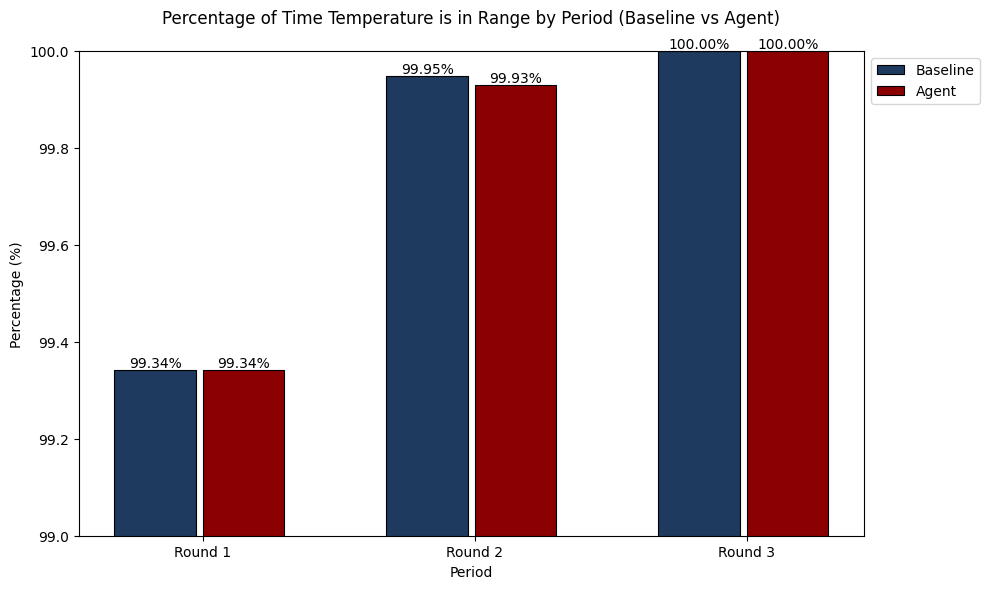

In [20]:
# Extract the temperature proportions (percentage of times the temperature is in range) from each list
rounds = ['Round 1', 'Round 2', 'Round 3']
proportions_agent = [Summer_test[0], Fall_test[0], Winter_test[0]]
proportions_baseline = [Summer_baseline[0], Fall_baseline[0], Winter_baseline[0]]

# Plotting the bar plot for temperature proportions by round
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.3
index = np.arange(len(rounds))

bars1 = ax.bar(index, [p * 100 for p in proportions_baseline], bar_width, label='Baseline',
               color='#1E3A5F', edgecolor='black', linewidth=0.8)  # Navy Blue with black border
bars2 = ax.bar(index + bar_width + 0.025, [p * 100 for p in proportions_agent], bar_width, label='Agent',
               color='#8B0000', edgecolor='black', linewidth=0.8)  # Dark Red with black border

ax.set_xlabel('Period')
ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of Time Temperature is in Range by Period (Baseline vs Agent)', pad=20)  # Increased padding
ax.set_xticks(index + bar_width / 2 + 0.025)
ax.set_xticklabels(rounds)

ax.set_ylim(99, 100)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}%', 
            ha='center', va='bottom', fontsize=10)

for bar in bars2:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}%', 
            ha='center', va='bottom', fontsize=10)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.5)

plt.tight_layout()
plt.show()

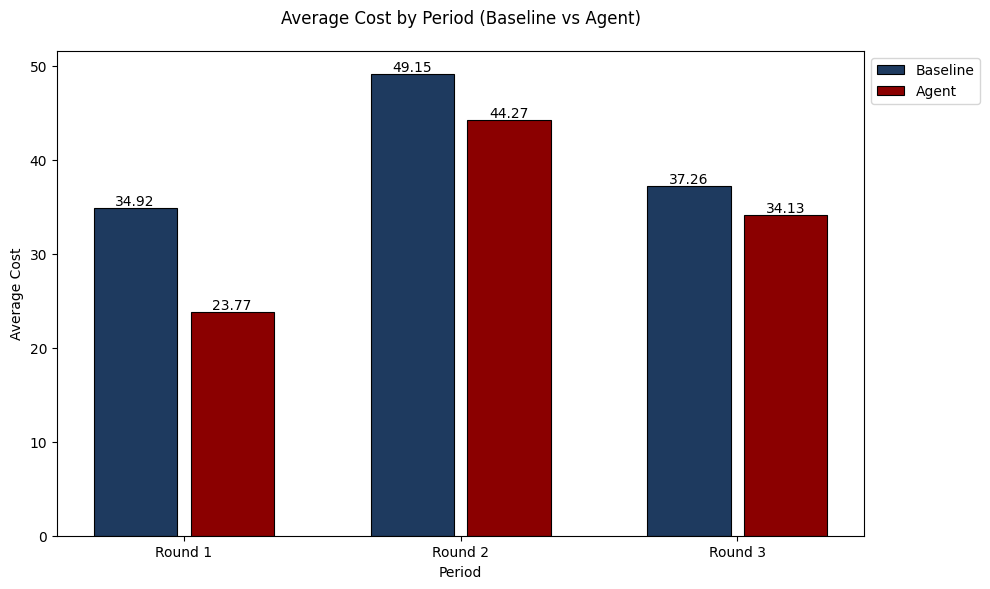

In [21]:
import matplotlib.pyplot as plt
import numpy as np

rounds = ['Round 1', 'Round 2', 'Round 3']
average_costs_agent = [np.mean(Summer_test[1]), np.mean(Fall_test[1]), np.mean(Winter_test[1])]
average_costs_baseline = [np.mean(Summer_baseline[1]), np.mean(Fall_baseline[1]), np.mean(Winter_baseline[1])]

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.3  # Slightly reduced bar width for spacing
index = np.arange(len(rounds))

bars1 = ax.bar(index, average_costs_baseline, bar_width, label='Baseline',
               color='#1E3A5F', edgecolor='black', linewidth=0.8)  # Navy Blue with black border
bars2 = ax.bar(index + bar_width + 0.05, average_costs_agent, bar_width, label='Agent',
               color='#8B0000', edgecolor='black', linewidth=0.8)  # Dark Red with black border

ax.set_xlabel('Period')
ax.set_ylabel('Average Cost')
ax.set_title('Average Cost by Period (Baseline vs Agent)', pad=20)  # Increased padding
ax.set_xticks(index + bar_width / 2 + 0.025)
ax.set_xticklabels(rounds)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
            ha='center', va='bottom', fontsize=10)

for bar in bars2:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
            ha='center', va='bottom', fontsize=10)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.5)

plt.tight_layout()
plt.show()

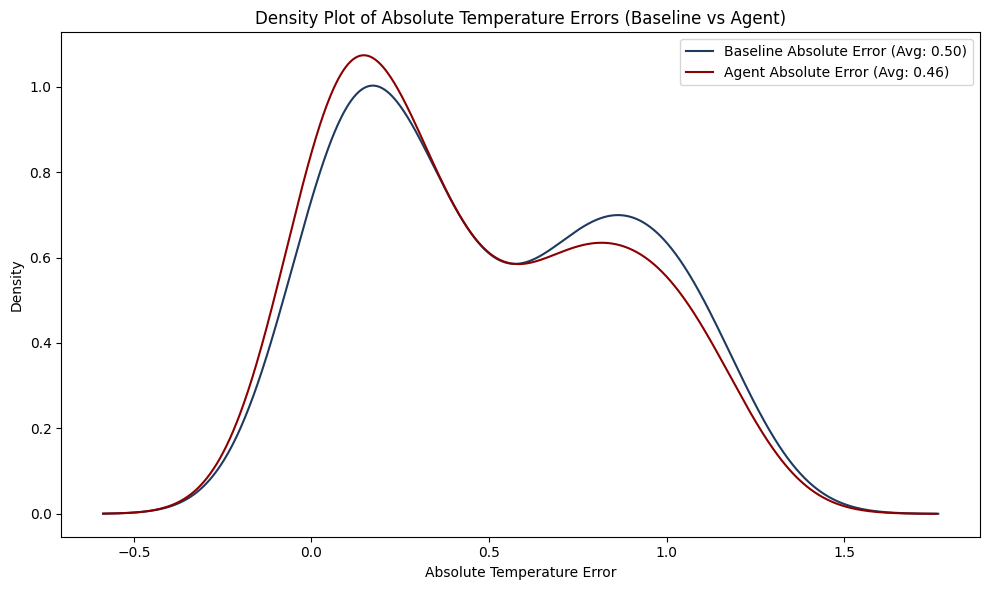

In [22]:
baseline_errors = pd.Series(All_baseline[2])
agent_errors = pd.Series(All_test[2])

avg_baseline_error = np.mean(baseline_errors)
avg_agent_error = np.mean(agent_errors)

plt.figure(figsize=(10, 6))
baseline_errors.plot(kind='density', label=f'Baseline Absolute Error (Avg: {avg_baseline_error:.2f})', color='#1E3A5F')  # Navy Blue
agent_errors.plot(kind='density', label=f'Agent Absolute Error (Avg: {avg_agent_error:.2f})', color='#8B0000')  # Dark Red

plt.title('Density Plot of Absolute Temperature Errors (Baseline vs Agent)')
plt.xlabel('Absolute Temperature Error')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()



### I redefine the PPO Agent to create a dataframe with useful information to plot the results

In [32]:
baseline_batches, agent_batches = get_results(dfcomplete_test)

temperature in range:  99.78 %
avg cost:  41.022796272968044
avg error:  0.49948147510608426
avg reward:  -0.03370732642811302
temperature in range:  99.77 %
avg cost:  34.73801479587033
avg error:  0.4591394402068403
avg reward:  -0.02864169658104887


In [37]:
import matplotlib.pyplot as plt
import pandas as pd

def combine_date_time(row):
    return pd.to_datetime(f"{row['Date']} {row['Time']}")

def plot_combined_temperature_trajectory(agent_batch, baseline_batch, days = None):
    agent_batch['DateTime'] = agent_batch.apply(combine_date_time, axis=1)
    baseline_batch['DateTime'] = baseline_batch.apply(combine_date_time, axis=1)
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(baseline_batch['DateTime'], baseline_batch['Temperature'], label='Baseline Temperature', color='#1E3A5F', marker='o', markersize=2)
    plt.plot(baseline_batch['DateTime'], baseline_batch['Upper_bound'], label='Upper Bound', color='red', linestyle='--')
    plt.plot(baseline_batch['DateTime'], baseline_batch['Lower_bound'], label='Lower Bound', color='green', linestyle='--')
    
    plt.plot(agent_batch['DateTime'], agent_batch['Temperature'], label='Agent Temperature', color='#8B0000', marker='x', markersize=2)
    
    plt.xlabel('DateTime',fontsize=14)
    plt.ylabel('Temperature',fontsize=14)
    title = 'Baseline vs Agent Temperature Trajectory - ' + days
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    
    plt.legend(loc='upper right')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

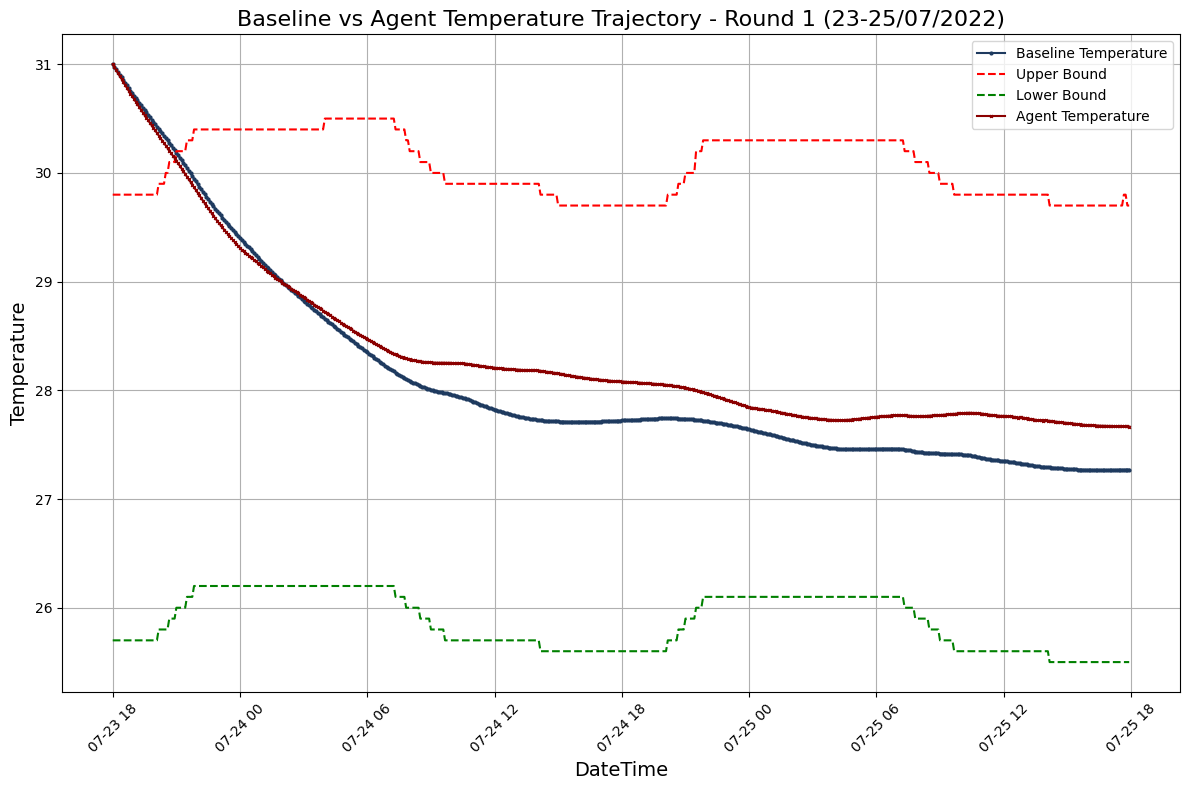

In [38]:
plot_combined_temperature_trajectory(agent_batches[12], baseline_batches[12], days = 'Round 1 (23-25/07/2022)')

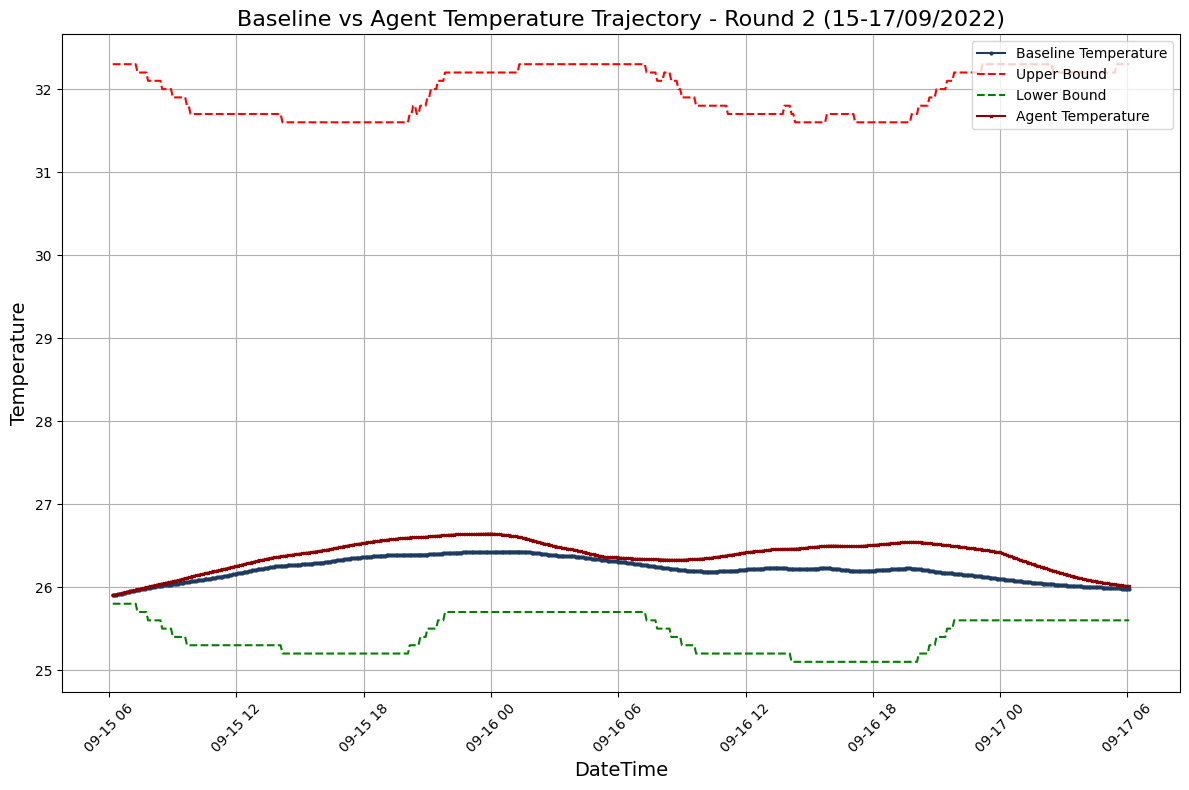

In [39]:
plot_combined_temperature_trajectory(agent_batches[15], baseline_batches[15], days = 'Round 2 (15-17/09/2022)')

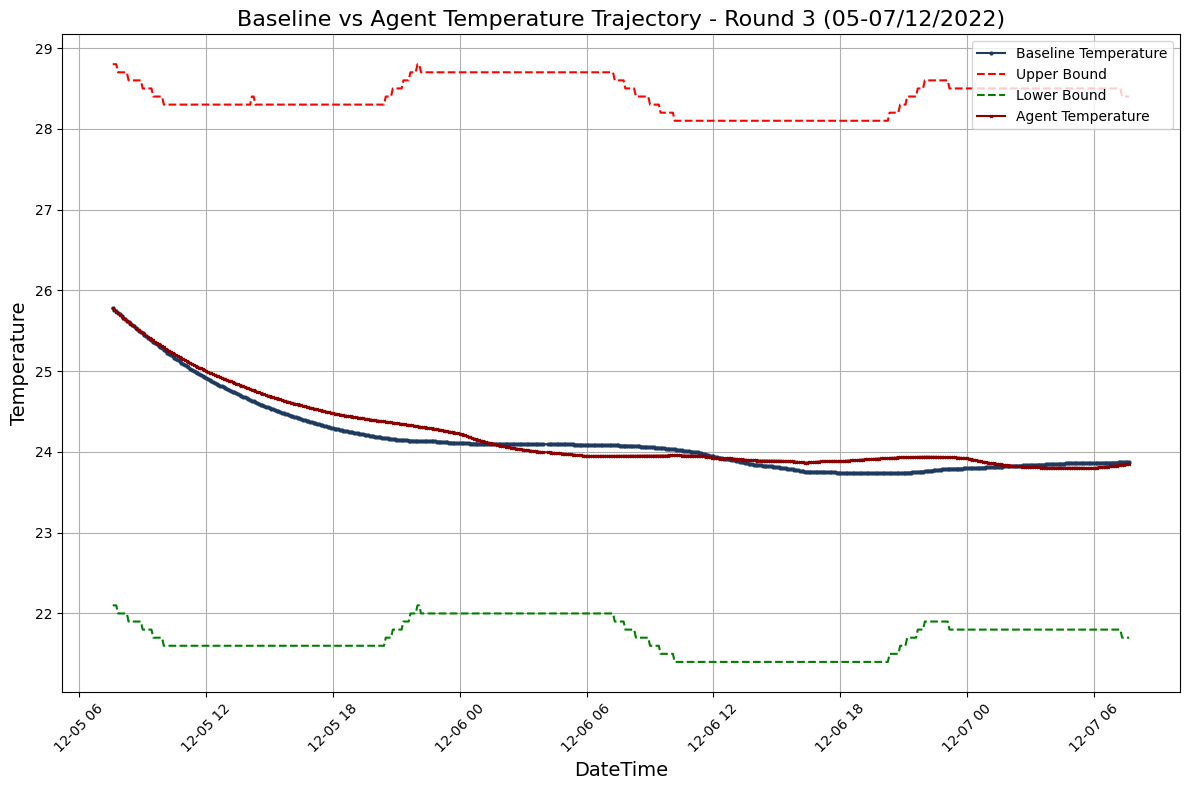

In [40]:
plot_combined_temperature_trajectory(agent_batches[40], baseline_batches[40], days = 'Round 3 (05-07/12/2022)')

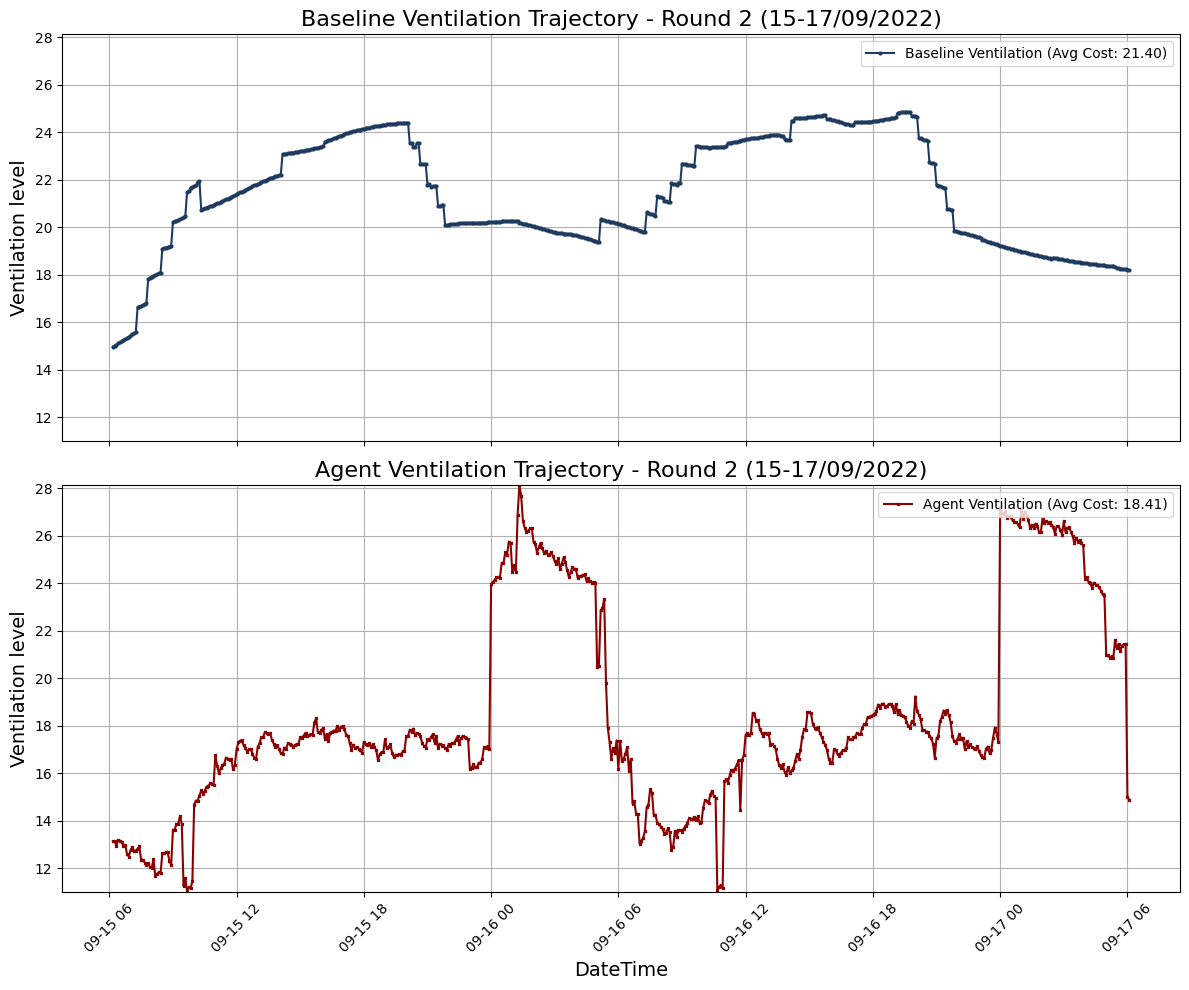

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

def combine_date_time(row):
    return pd.to_datetime(f"{row['Date']} {row['Time']}")

def plot_agent_baseline_vent(agent_batch, baseline_batch, days = None):
    agent_batch['DateTime'] = agent_batch.apply(combine_date_time, axis=1)
    baseline_batch['DateTime'] = baseline_batch.apply(combine_date_time, axis=1)

    avg_baseline_cost = baseline_batch['Cost'].mean()
    avg_agent_cost = agent_batch['Cost'].mean()

    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot Baseline Ventilation
    axes[0].plot(baseline_batch['DateTime'], baseline_batch['Cost'], label=f'Baseline Ventilation (Avg Cost: {avg_baseline_cost:.2f})', color='#1E3A5F', marker='o', markersize=2)
    axes[0].set_ylabel('Ventilation level', fontsize=14)
    title = 'Baseline Ventilation Trajectory - ' + days
    axes[0].set_title(title, fontsize=16)
    axes[0].legend(loc='upper right')
    axes[0].grid(True)

    # Plot Agent Ventilation
    axes[1].plot(agent_batch['DateTime'], agent_batch['Cost'], label=f'Agent Ventilation (Avg Cost: {avg_agent_cost:.2f})', color='#8B0000', marker='x', markersize=2)
    axes[1].set_xlabel('DateTime', fontsize=14)
    axes[1].set_ylabel('Ventilation level', fontsize=14)
    title = 'Agent Ventilation Trajectory - ' + days
    axes[1].set_title(title,fontsize=16)
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    # Set the same y-axis limits for both plots
    y_min = min(baseline_batch['Cost'].min(), agent_batch['Cost'].min())
    y_max = max(baseline_batch['Cost'].max(), agent_batch['Cost'].max())
    axes[0].set_ylim(y_min, y_max)
    axes[1].set_ylim(y_min, y_max)

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

# Example usage
plot_agent_baseline_vent(agent_batches[15], baseline_batches[15], days = 'Round 2 (15-17/09/2022)')

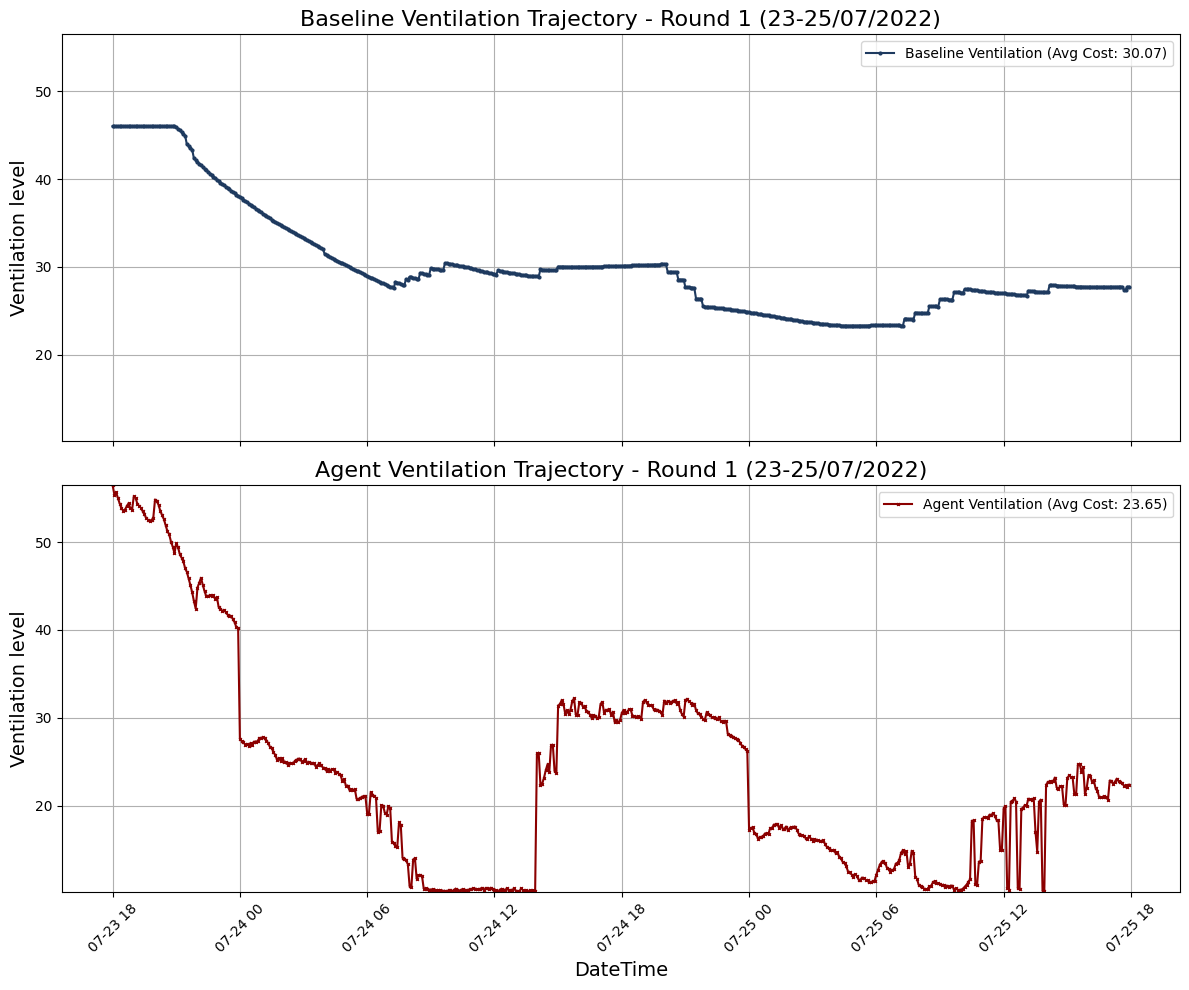

In [45]:
plot_agent_baseline_vent(agent_batches[12], baseline_batches[12], days = 'Round 1 (23-25/07/2022)')

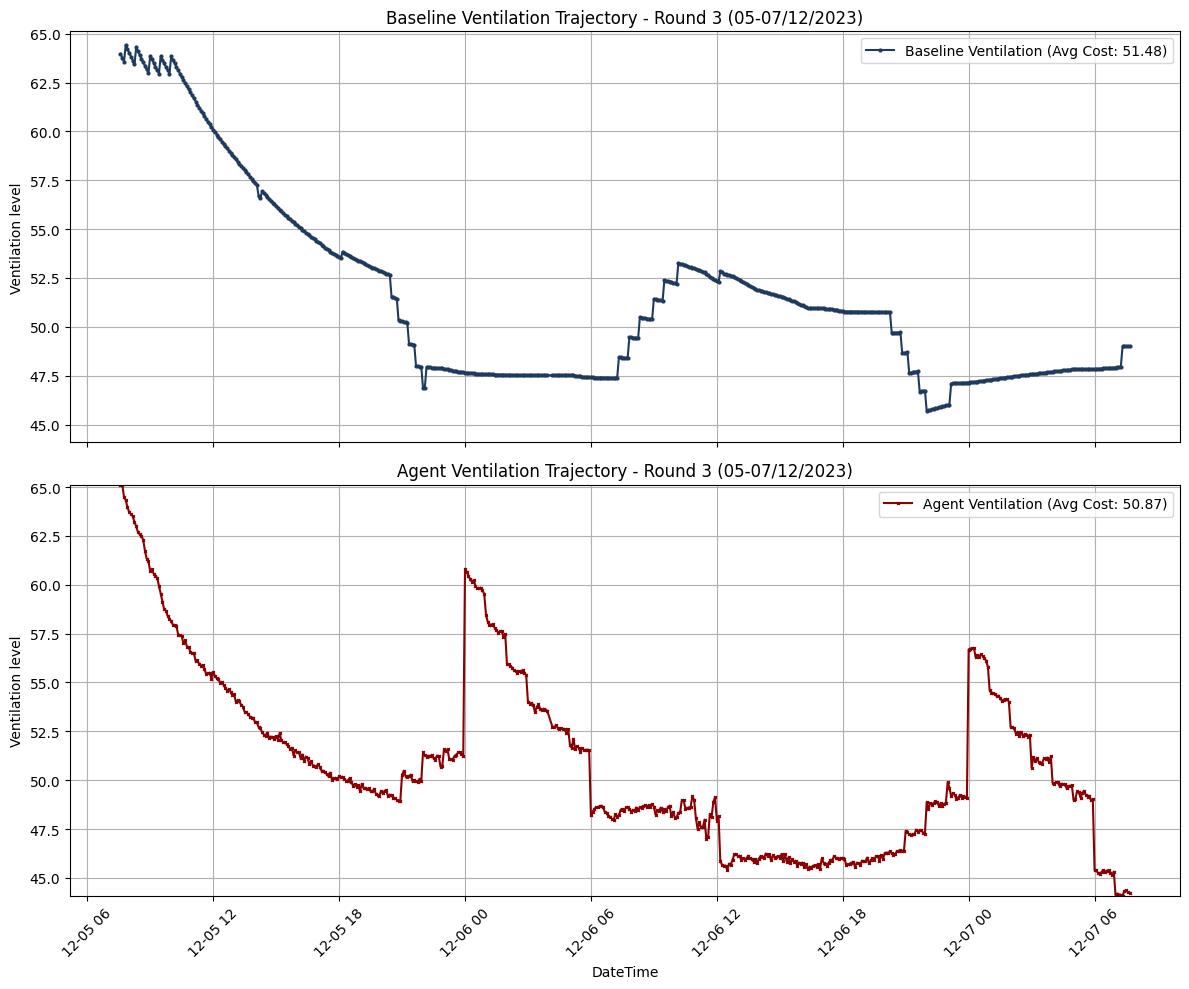

In [18]:
plot_agent_baseline_vent(agent_batches[40], baseline_batches[40], days = 'Round 3 (05-07/12/2023)')